In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
mpl.rcParams["font.family"] = 'Arial'
mpl.rcParams["mathtext.fontset"] = 'cm'
import meshio
import matplotlib.tri as mtri
import h5py
from matplotlib.ticker import MultipleLocator
import linecache
from matplotlib import ticker
from matplotlib.ticker import LogLocator
from matplotlib import cm
import os
import copy
# read vtk 
import numpy
from vtk import vtkRectilinearGridReader
from vtk.util import numpy_support as VN
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import iapws
IAPWS97_TCRIT = 647.096  #/* K */
IAPWS97_PCRIT = 22.064e6 #/* Pa */
IAPWS97_RHOCRIT = 322. #/* kg/m³ */
IAPWS97_TTRIP = 623.15
# IAPWS97_PTrip = iapws.iapws97._P23_T(IAPWS97_TTRIP)

path_figures='../../../../../_figures'

## Phase diagram of water

In [21]:
def plot_prop(path_data,prop,ax,cmap='YlGnBu',nlevel=10,scale_prop=1,showContour=False,logScale=False,vmin=None,vmax=None,extend='neither'):
    TT=np.loadtxt(path_data+'/TT.dat')
    PP=np.loadtxt(path_data+'/PP.dat')
    Prop=np.loadtxt(path_data+'/'+prop+'.dat')*scale_prop
    if(logScale):
        print(Prop[Prop==0].shape, Prop[Prop>0].shape, Prop[Prop<0].shape)
        ind_pos=(Prop>0)
        ind_neg=(Prop<0)
        Prop[ind_pos]=np.log10(Prop[ind_pos])
        Prop[ind_neg]=np.log10(-Prop[ind_neg])
        Prop[Prop==0]=Prop.min()
    Density=Prop.copy()
    if(not prop=='RHO'):
        Density=np.loadtxt(path_data+'/RHO.dat')
    #levels=np.linspace(np.min(Prop),np.max(Prop),nlevel)
    if(vmin==None):
        vmin=Prop.min()
    if(vmax==None):
        vmax=Prop.max()
    norm = cm.colors.Normalize(vmax=vmax, vmin=vmin)
    print('vmin: ',vmin,'vmax:',vmax)
    levels=np.linspace(vmin,vmax,nlevel)
    CSf=ax.contourf(TT,PP/1e5,Prop,cmap=cmap,levels=levels,extend=extend,norm=norm)
    if(showContour):
        CS=ax.contour(TT,PP/1e5,Prop,levels=levels,colors='k',linewidths=0.3,linestyles='dashed')
    ax.set_xlim(0,990)
    ax.set_ylim(0,990)
    
    
    # text and critical- pressure, temperautre, density
    CS=ax.contour(TT,PP/1e5,Density,levels=[IAPWS97_RHOCRIT],linestyles='dashed',linewidths=1,colors='r')
    iso_density= CS.allsegs[0][0]
    x_iso=iso_density[:,0]
    y_iso=iso_density[:,1]
    ind=(x_iso< (IAPWS97_TCRIT-273.15))
#     ax.plot(x_iso[ind],y_iso[ind],color='k')
    ax.hlines(y=IAPWS97_PCRIT/1e5, xmin=IAPWS97_TCRIT-273.15, xmax=np.max(TT),color='k')
    ax.vlines(x=IAPWS97_TCRIT-273.15, ymin=IAPWS97_PCRIT/1e5, ymax=np.max(PP/1e5),color='k')
    ax.text(500, IAPWS97_PCRIT/1e5+10, 'Critical pressure',va='bottom',color='r',fontweight='bold')
    ax.text(IAPWS97_TCRIT-273.15-20, np.max(PP)/1e5-20, 'Critical temperature',va='top',ha='right',rotation=90,color='r',fontweight='bold')
    ax.text(550, 600, 'Critical density',va='center',ha='center',rotation=70,color='r',fontweight='bold')
    ax.text(450, np.max(PP)/1e5-20, 'Liquid like fluid',va='top',ha='center',rotation=90)
    ax.text(650, 850, 'Vapour like fluid',va='center',ha='left')
    ax.text(700,500,'Supercritical fluid',ha='center',va='center',rotation=45,fontweight='bold')
    ax.text(100,600,'Liquid',ha='center',va='center',fontweight='bold')
    ax.text(600,180,'Vapour',ha='center',va='center',fontweight='bold')
    ax.annotate("Vapour-liquid\nequilibrium",va='center',ha='right',
                color='k',fontweight='bold', xy=(x_iso[300], y_iso[300]), 
                xycoords='data',xytext=(200,100), textcoords="data",
                arrowprops=dict(arrowstyle="->"))
    return CSf,TT,PP,np.array([vmin,vmax])

vmin:  0.170331 vmax: 1045.233412


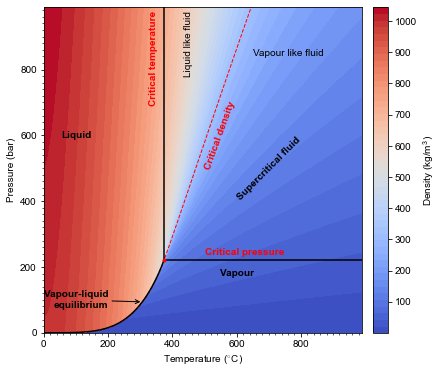

In [24]:
fig,axs=plt.subplots(1,2,sharex=False,sharey=False,
                     gridspec_kw={"width_ratios":[1,0.05],"height_ratios":[1]},
                         figsize=(5.9,5),constrained_layout=False)
# Density of pure water
ax=axs[0]
CSf,TT,PP,Prop=plot_prop('data','Rho',ax,nlevel=50,cmap='coolwarm')
ax.set_ylabel('Pressure (bar)')
ax.set_xlabel('Temperature ($^{\circ}$C)')
ax.xaxis.set_minor_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(20))
# plot phase region boundary
# 1. region 2 and region 3
# T=np.linspace(IAPWS97_TTRIP, 1273.15, 200)
# P23=iapws.iapws97._P23_T(T)
# ax.plot(T-273.15,P23*10,'w')
# 2. region 4, saturated curve
T=np.linspace(273.15, 647.096,50)
PSat=[]
for i in range(0, len(T)):
    PSat.append(iapws.iapws97._PSat_T(T[i]))
PSat=np.array(PSat)
ax.plot(T-273.15, PSat*10,'k')
# 3. region 1 and region 3
# ax.vlines(x=IAPWS97_TTRIP-273.15, ymin=IAPWS97_PTrip*10, ymax=1000,color='w')
# 4. critical point
ax.plot(IAPWS97_TCRIT-273.15, IAPWS97_PCRIT/1e5,'.',color='r')
# colorbar
ax=axs[1]
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.axis('off')
caxis = inset_axes(ax,
                   width="100%",  # width = 10% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0.05, 0., 0.95, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
cb = plt.colorbar(CSf, cax = caxis,format='%.0f')  
# caxis.xaxis.set_ticks_position("top")
# caxis.xaxis.set_label_position("top")
cb.set_label('Density (kg/m$^{\mathregular{3}}$)')
cb.set_ticks(range(0,1001,100))

 
whspace=0.06
plt.subplots_adjust(wspace=whspace,hspace=whspace,bottom=0.085,left=0.09,right=0.9,top=0.99)

plt.savefig(path_figures+'/PhaseDiagram.pdf')
plt.savefig(path_figures+'/PhaseDiagram.svg')
plt.show()